# ShapRFECV vs sklearn RFECV

In this section we will compare the performance of the model trained on the features selected using the probatus [ShapRFECV](https://ing-bank.github.io/probatus/api/feature_elimination.html) and the [sklearn RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).

In order to compare them let's first prepare a dataset, and a model that will be applied:

In [1]:
from probatus.feature_elimination import ShapRFECV
import numpy as np
import pandas as pd
import lightgbm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

# Prepare train and test data:
X, y = make_classification(n_samples=10000, class_sep=0.1, n_informative=40, n_features=50,
                           random_state=0, n_clusters_per_class=10)
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Set up the model:
clf = lightgbm.LGBMClassifier(n_estimators=10, num_leaves=7)

Now, we can run ShapRFECV and RFECV with the same parameters, to extract the optimal feature sets:

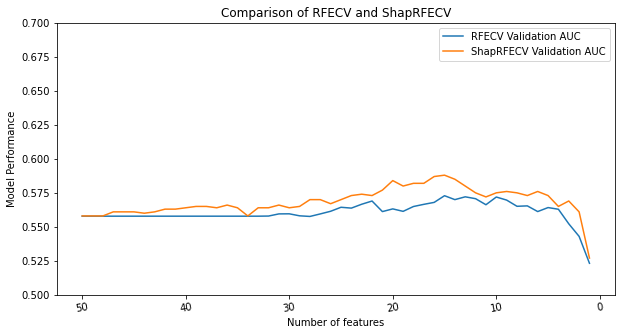

In [2]:
# Run RFECV and ShapRFECV with the same parameters
rfe = RFECV(clf, step=1, cv=20, scoring='roc_auc', n_jobs=3).fit(X_train, y_train)
shap_elimination = ShapRFECV(clf=clf, step=1, cv=20, scoring='roc_auc', n_jobs=3)
shap_report = shap_elimination.fit_compute(X_train, y_train)

# Compare the CV Validation AUC for different number of features in each method.
ax = pd.DataFrame({'RFECV Validation AUC': list(reversed(rfe.grid_scores_)),
                   'ShapRFECV Validation AUC': shap_report['val_metric_mean'].values.tolist()}, 
                 index=shap_report['num_features'].values.tolist()).plot(ylim=(0.5,0.7), rot=10, title='Comparison of RFECV and ShapRFECV', figsize=(10,5))
ax.set_ylabel("Model Performance")
ax.set_xlabel("Number of features")
ax.invert_xaxis()
plt.show()

The plot above presents the averaged CV Validation AUC of model performance for each round of the RFE process in both ShapRFECV and RFECV. The optimal number of features is 21 for the former, and 13 for the latter.

Now we will compare the performance of the model trained on:

- All 50 available features (baseline),
- 13 features selected by RFECV (final),
- 21 features selected by ShapRFECV (final),
- 13 feature selected by ShapRFECV (baseline).

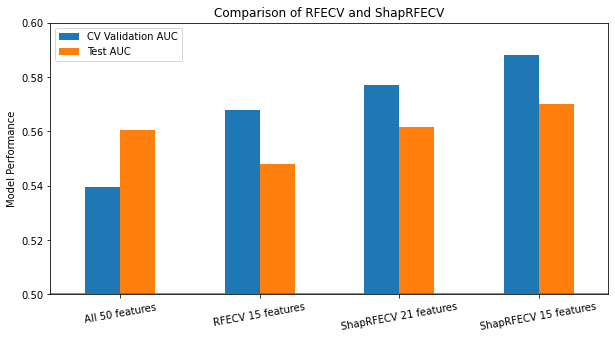

In [3]:
n_features_shap = 21
n_features_rfecv = rfe.n_features_

# Calculate the AUC for the models with different feature sets
test_auc_full = clf.fit(X_train, y_train).score(X_test, y_test)
val_auc_full =  np.mean(cross_val_score(clf, X_train, y_train, cv=10))

rfe_features_set = X_train.columns[rfe.support_]
test_auc_rfe = clf.fit(X_train[rfe_features_set], y_train).score(X_test[rfe_features_set], y_test)
val_auc_rfe = rfe.grid_scores_[n_features_rfecv]

shap_feature_set = X_train.columns[shap_elimination.get_reduced_features_set(n_features_shap)]
test_auc_shap = clf.fit(X_train[shap_feature_set], y_train).score(X_test[shap_feature_set], y_test)
val_auc_shap = shap_report[shap_report.num_features == n_features_shap]['val_metric_mean'].values[0]

shap_feature_set_size_rfe = X_train.columns[shap_elimination.get_reduced_features_set(n_features_rfecv)]
test_auc_shap_size_rfe = clf.fit(X_train[shap_feature_set_size_rfe], y_train).score(X_test[shap_feature_set_size_rfe], y_test)
val_auc_shap_size_rfe = shap_report[shap_report.num_features == n_features_rfecv]['val_metric_mean'].values[0]

# Plot Test and Validation Performance
variants = ('All 50 features', f'RFECV {n_features_rfecv} features', f'ShapRFECV {n_features_shap} features', f'ShapRFECV {n_features_rfecv} features')
results_test = [test_auc_full, test_auc_rfe, test_auc_shap, test_auc_shap_size_rfe]
results_val = [val_auc_full, val_auc_rfe, val_auc_shap, val_auc_shap_size_rfe]

ax = pd.DataFrame({'CV Validation AUC': results_val,
                   'Test AUC': results_test}, index=variants).plot.bar(ylim=(0.5,0.6), rot=10, title='Comparison of RFECV and ShapRFECV', figsize=(10,5))
plt.axhline(y=0.5)
ax.set_ylabel("Model Performance")
plt.show()

As shown in the plot, ShapRFECV provides superior results for both: CV Validation and Test AUC, compared to RFECV and the baseline model with all the available features. Not only the introduced method allows to eliminate features without the loss in performance, but also it may increase the performance of the model.

When it comes to time required to perform the feature selection in the experiment above, RFECV takes 6.11 s ± 33.7 ms, while ShapRFECV takes 10.1 s ± 72.8 mss, which shows that the latter is more computation expensive, due to SHAP values calculation.